# Training a PIX2PIX Model using PyTorch / ONNX

This notebook walks you through the steps of training your own image-to-image machine learning model.

In [1]:
# Make sure you are connected to a runtime with a GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-59ba7a4d-461d-6c44-7eea-a4200c322183)


In [2]:
# Install ONNX (not installed by default)
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
%pip install -q onnx

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import all other dependencies
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import random
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from types import SimpleNamespace
from IPython.display import clear_output

In [4]:
# Check if GPU is available
gpu_available = torch.cuda.is_available()
print("GPU is", "available" if gpu_available else "NOT AVAILABLE")

GPU is available


In [ ]:
# Download a pre-existing dataset
!curl -O https://algorithmicgaze.s3.amazonaws.com/datasets/faces_contour.zip
!mkdir -p datasets/faces
!unzip -j -o -qq *.zip -d datasets/faces
# Remove macOS metadata cruft
!rm -rf datasets/faces/._*

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  364M  100  364M    0     0  17.5M      0  0:00:20  0:00:20 --:--:-- 28.3M


In [5]:
# Some helper functions for creating/checking directories.

def directory_should_exist(*args):
    dir = os.path.join(*args)
    if not os.path.isdir(dir):
        raise Exception("Path '{}' is not a directory.".format(dir))
    return dir

def ensure_directory(*args):
    dir = os.path.join(*args)
    os.makedirs(dir, exist_ok=True)
    return dir

In [6]:
input_dir = directory_should_exist("datasets/faces_pixelated")
output_dir = ensure_directory("output")
sample_interval = 300
snapshot_interval = 1
epochs = 100
batch_size = 8

In [7]:
# Create the dataset class
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(root_dir) if f.endswith(".jpg") or f.endswith(".png")
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)

        # Split the image into input and target
        w, h = image.size
        target_image = image.crop((0, 0, w // 2, h))
        input_image = image.crop((w // 2, 0, w, h))

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

In [8]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = Pix2PixDataset(input_dir, transform=transform)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

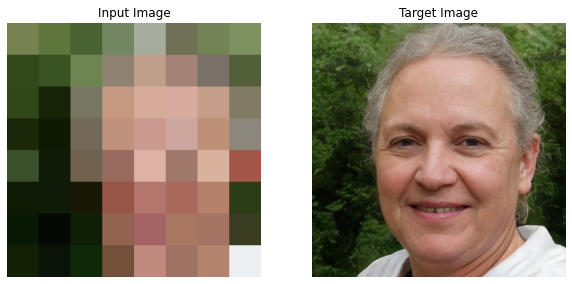

In [9]:
# Show a single image from the dataset

def plot_image(subplot, title, img):
    img = (img + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    subplot.imshow(img)
    subplot.set_title(title)
    subplot.axis("off")

input_img, target_img = next(iter(dataloader))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_image(ax1, "Input Image", input_img[0])
plot_image(ax2, "Target Image", target_img[0])
plt.show()

In [10]:
# Implement the UNet architecture for the generator
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, bn=True, dropout=False):
        super(UNetBlock, self).__init__()
        self.conv = (
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        )
        self.bn = nn.BatchNorm2d(out_channels) if bn else None
        self.dropout = nn.Dropout(0.5) if dropout else None
        self.act = nn.LeakyReLU(0.2) if down else nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.dropout:
            x = self.dropout(x)
        return self.act(x)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.down1 = UNetBlock(3, 64, down=True, bn=False)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512)
        self.down5 = UNetBlock(512, 512)
        self.down6 = UNetBlock(512, 512)
        self.down7 = UNetBlock(512, 512)
        self.down8 = UNetBlock(512, 512, bn=False)

        self.up1 = UNetBlock(512, 512, down=False, dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final(torch.cat([u7, d1], 1))

In [12]:
# Implement the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            UNetBlock(6, 64, bn=False),
            UNetBlock(64, 128),
            UNetBlock(128, 256),
            UNetBlock(256, 512),
            nn.Conv2d(512, 1, 4, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], 1))

In [13]:
# Define the loss functions and optimizers
criterion_gan = nn.BCELoss()
criterion_pixel = nn.L1Loss()

In [14]:
# Load snapshot if available
def get_latest_snapshot(output_dir):
    snapshots = glob.glob(os.path.join(output_dir, "snapshot_epoch_*.pth"))
    if not snapshots:
        return None
    return max(snapshots, key=os.path.getctime)

def get_latest_generator(output_dir):
    generators = glob.glob(os.path.join(output_dir, "generator_epoch_*.onnx"))
    if not generators:
        return None
    return max(generators, key=os.path.getctime)

In [15]:
def load_snapshot(generator, discriminator, g_optimizer, d_optimizer, snapshot_path):
    checkpoint = torch.load(snapshot_path, map_location=device, weights_only=False)
    generator.load_state_dict(checkpoint["generator"])
    discriminator.load_state_dict(checkpoint["discriminator"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer"])
    start_epoch = int(os.path.basename(snapshot_path).split("_")[2].split(".")[0])
    return start_epoch

In [16]:
# Create the training loop
def train(generator, discriminator, dataloader, opts):
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Get fixed input/output for visualization
    fixed_set = next(iter(dataloader))
    fixed_input = fixed_set[0][0].unsqueeze(0)
    fixed_target = fixed_set[1][0].unsqueeze(0)
    # fixed_input = next(iter(dataloader))[0][0].unsqueeze(0)  # Get a fixed input for visualization

    start_epoch = 1
    if not opts.restart:
        latest_snapshot = get_latest_snapshot(opts.output_dir)
        if latest_snapshot:
            latest_epoch = load_snapshot(
                generator, discriminator, g_optimizer, d_optimizer, latest_snapshot
            )
            # The last epoch was
            start_epoch = latest_epoch + 1
            print(f"Resuming training from epoch {latest_epoch}")
        else:
            print("No snapshots found. Starting from scratch.")
    else:
        print("Restarting training from scratch.")

    for epoch in range(start_epoch, start_epoch + opts.epochs):
        for i, (input_img, target_img) in enumerate(tqdm(dataloader)):
            input_img = input_img.to(device)
            target_img = target_img.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            fake_img = generator(input_img)
            d_real = discriminator(input_img, target_img)
            d_fake = discriminator(input_img, fake_img.detach())
            d_loss_real = criterion_gan(d_real, torch.ones_like(d_real))
            d_loss_fake = criterion_gan(d_fake, torch.zeros_like(d_fake))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_img = generator(input_img)
            d_fake = discriminator(input_img, fake_img)
            g_loss_gan = criterion_gan(d_fake, torch.ones_like(d_fake))
            g_loss_pixel = criterion_pixel(fake_img, target_img) * 100
            g_loss = g_loss_gan + g_loss_pixel
            g_loss.backward()
            g_optimizer.step()

            if i % opts.sample_interval == 0:
                with torch.no_grad():
                    fake_img = generator(fixed_input.to(device))
                    img_sample = torch.cat(
                        (fixed_input.cpu(), fake_img.cpu(), fixed_target.cpu()), -1
                    )
                    img_sample = (img_sample + 1) / 2
                    np_img = img_sample.squeeze(0).numpy().transpose((1, 2, 0))
                    clear_output(wait=True)
                    print(f"Epoch {epoch}")
                    plt.figure(figsize=(10, 5))
                    plt.imshow(np_img)
                    plt.axis('off')
                    plt.show()

                    image_path = f"{opts.output_dir}/epoch_{epoch}_iter_{i}.jpg"
                    save_image(
                        img_sample,
                        image_path,
                        nrow=3,
                        normalize=True,
                    )

        if (epoch + 1) % opts.snapshot_interval == 0:
            torch.save(
                {
                    "generator": generator.state_dict(),
                    "discriminator": discriminator.state_dict(),
                    "g_optimizer": g_optimizer.state_dict(),
                    "d_optimizer": d_optimizer.state_dict(),
                },
                f"{opts.output_dir}/snapshot_epoch_{epoch}.pth",
            )

            # Save to ONNX format
            onnx_path = f"{opts.output_dir}/generator_epoch_{epoch}.onnx"
            generator.eval()
            dummy_input = torch.randn(1, 3, 512, 512).to(device)
            traced_script_module = torch.jit.trace(generator, dummy_input)
            torch.onnx.export(
                traced_script_module,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=["input"],
                output_names=["output"],
                dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
            )
            print(f"ONNX model exported to {onnx_path}")
            generator.train()


Epoch 51


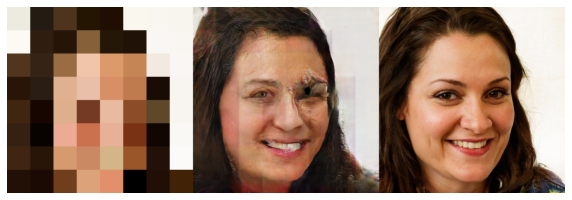

 81%|██████████████████████████████████████████████████████████████████▋               | 508/625 [00:49<00:11, 10.33it/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

opts = {
    "output_dir": output_dir,
    "sample_interval": sample_interval,
    "snapshot_interval": snapshot_interval,
    "epochs": epochs,
    "restart": False,
}
train(generator, discriminator, dataloader, SimpleNamespace(**opts))

## Optional: Copy the generator model to Google Drive

You can save some time downloading/uploading the generator by using Google Drive. In the next steps we'll connect to Google Drive and upload the generator. The conversion Colab notebook will look for this zip file and convert it.

In [ ]:
# Step 1: Mount Google Drive. This will ask for permissions.
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Step 2: Copy the generator.zip to Google Drive
import shutil
drive_folder = '/drive/MyDrive/2024-raive'
ensure_directory(drive_folder)
shutil.copy(get_latest_generator(output_dir), drive_folder)

'/drive/MyDrive/2024-raive/generator_epoch_8.onnx'